<a href="https://colab.research.google.com/github/lphansen/RiskUncertaintyValue/blob/main/expansion_suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Hansen, Khorrami and Tourre (2024)

We previously covered the small-noise expansion method and the recursive utility framework. This section covers the usage of `Expansion Suite`, an open source Python toolbox which uses these methods to solve discrete nonlinear DSGE models.

This notebook provides both written explanations and accompanying code. The simplest way to run the code is to open the Google Colab link at the top of this page. Otherwise, the reader can copy the code snippets onto their local machine.

<!-- For this notebook 

- Section 1 provides a five-minute guide to solving the DSGE model using the expansion suite, as well as how to 
    - compute shock elasticities and IRF
    - approximate and simulate variables based on model solutions. 


- Section 2 provides examples of `LinQuadVar` computations, including
    - constructions, operations, and evaluations
    - adjusting time periods
    - computing expectations -->


<!-- **Table of Contents**
* [1. Five-minute guide to solving the DSGE model using the Expansion Suite](#s1)
    * [1.1 Equilibrium Condition Function](#s1-1)
    * [1.2 Model Steady State Function](#s1-2)
    * [1.3 Model Variable Dimension Array](#s1-3)
    * [1.4 Model Parameter Calibration Tuple](#s1-4)
    * [1.5 Log Consumption Growth Function](#s1-5)
    * [1.6 Solve the BY model using the Expansion Suite](#s1-6)
    * [1.7 Model Solutions](#s1-7)
    * [1.8 Approximate Variables](#s1-8)
    * [1.9 Model Simulations](#s1-9)
    * [1.10 Shock Elasticities and IRF](#s1-10)
* [2. Examples to use `LinQuadVar` in Computation](#s2)
    * [2.1 Define a `LinQuadVar` ](#s2-1)
    * [2.2 `LinQuadVar` Operations](#s2-2)
    * [2.3 `LinQuadVar` Split and Concat](#s2-3)
    * [2.4 Evaluate a `LinQuadVar`](#s2-4)
    * [2.5 Adjust Conditional Information Time](#s2-5)
    * [2.6 Compute the Expectation of time $t+\epsilon$](#s2-6) -->


```{contents}
:depth: 1
```

Consider the framework previously introduced:

$$
\begin{align}
\mathbb{E}[{N_{t+\epsilon}^*Q_{t+\epsilon}^* \psi_1(X_t, J_t, X_{t+\epsilon}, J_{t+\epsilon})}|{\mathfrak{A}_t}] - \psi_2(X_t, J_t)  &= 0 \tag{1}\\
  \phi\left(X_t, X_{t+\epsilon}, J_t, {\sf q}W_{t+\epsilon}, {\sf q} \right) &= 0 
\tag{2} \end{align}
$$

The `Expansion Suite` uses the function `uncertain_expansion` to approximate a solution to the above system locally. It takes the following inputs:

```{list-table}
:header-rows: 1

* - Input
  - Type
  - Description
* - `eq`
  - *callable*
  - Function which takes state and jump variables and outputs error of equilibrium conditions, i.e. RHS of equation (1)
* - `ss`
  - *callable*
  - Function which takes model parameters and outputs steady-state values of state and jump variables
* - `var_shape`
  - *tuple of int*
  - Triple of integers $(n_J,n_X,n_W)$ where $n_J$ is the number of jump variables, $n_X$ is the number of state variables, and $n_W$ is the number of shocks.
* - `args`
  - *tuple of float or ndarray*
  - Array of preference and model parameters
* - `gc`
  - *callable*
  - Function which takes in variables and outputs log-growth of consumption
* - `args`
  - tuple of float/ndarray
  - Preference and model parameters
* - `gc`
  - *callable*
  - Function which takes in variables and outputs log-growth of consumption
* - `approach`
  - *string*
  - If equal to '1', then solve the model using approach 1 (default, see Appendix C); If equal to '2', then use approach 2 (see Appendix D). The function raises an exception if other values are provided
* - `init_util`
  - *dict, or None*
  - Dictionary for initialization of the expansion coefficients $\mu^0, \Upsilon_0^2, \Upsilon_1^2,$ and $\Upsilon_2^2$. The keys are: `mu_0`, `Upsilon_0`, `Upsilon_1`, `Upsilon_2`. If *None*, zero matrices are used
* - `iter_tol`
  - *float*
  - Iteration stops when the maximum absolute difference between the approximated variables in the current and previous iteration is below `iter_tol`
* - `max_iter`
  - *int*
  - Maximum number of iterations
```

The output is of class `ModelSolution`, which stores the coefficients for the linear-quadratic approximation for the jump and state variables; continuation values; consumption growth; and log change of measure, as well as the steady-state values of each variables. 

We will now walk through the computation using a simple example.
<br>
<br>

# 1 AK Model with Recursive Utility

This example is a discrete-time approximation of the model in Section 4.4 of {cite}`KhorramiTourreHansen:2024`. 
```{math}
C_t + I_t = \alpha K_t
```
Let  ${\widehat K}_t = \log K_t,$ ${\widehat C}_t = \log C_t$, and $\widehat{Z}_t^2 = \log Z_t^2$.  Then 
```{math}
:label: equation1
\begin{align} 
{{\widehat K}_{t+\epsilon}} - {\widehat K}_t = \hspace{.2cm} & \left[ {\frac 1 \zeta}  \log \left( 1 + \zeta \frac{I_t}{K_t} \right) + \beta_k Z_t^1 - \eta_k \right]\epsilon  \cr \hspace{.2cm} & +  \sqrt{Z_t^2}  {\sigma}_k \cdot \left[W_{t+\epsilon}  - W_t\right] - \frac{1}{2}|\sigma_k|^2 Z_t^2 \epsilon
\end{align} 
```
```{math}
:label: equation2
Z_{t+\epsilon}^1 -
Z_{t}^1=  - \beta_{1} Z_t^1 \epsilon +  \sqrt{Z_t^2} \sigma_1 \cdot \left(W_{t+\epsilon} - W_t \right)
```
```{math}
:label: equationz2
\begin{align}
{\widehat Z}_{t+\epsilon}^2 - {\widehat Z}_{t}^2 = \hspace{.2cm} &   - \beta_2 \left[ 1 - {\mu_2} \exp\left( - {\widehat Z}_t^2 \right) \right] \epsilon \cr \hspace{.2cm}&  - {\frac 1 2} |\sigma_2|^2  \exp\left( - {\widehat Z}_t^2 \right) \epsilon   
+ \exp\left( - {\frac 1 2}  {\widehat Z}_t^2 \right) \sigma_2 \cdot \left(W_{t+\epsilon} - W_t \right)
\end{align} 
```
Observe that $W_{t+\epsilon} - W_t $ is normally distributed mean zero and covariance $\epsilon {\mathbb I}$.  
Let $X_t = [Z_t^1 \hspace{.2cm} {\widehat Z}_t^2]$ and $D_t = \frac{I_t}{K_t}.$ Note that  
```{math}
:label: equation3
{\widehat C}_t = \log \left( \alpha - D_t \right) + {\widehat K}_t 
```
The first-order conditions for the investment-capital ratio imply that  
```{math}
:label: equation4
\begin{align*}
0 &= - (1-\beta) \exp\left[(1- \rho) \left({\widehat C}_t - {\widehat G}_t \right)\right] \left( \frac{1}{\alpha - D_t} \right) 
\\&+ \beta \exp\left[(1 - \rho) \left({\widehat R}_t - {\widehat G}_t \right)\right] \left(\frac{1}{1 + \zeta D_t} \right)    
\end{align*}
```  
The co-state equation is:  
```{math}
:label: equation5
\begin{align*}
MX_t = \hspace{.2cm} & \beta \exp\left[(1 - \rho) \left({\widehat R}_t - {\widehat V}_t \right)\right] 
{\mathbb E} 
\left(
\exp\left[(1 - \gamma) \left({\widehat V}_{t+1} - {\widehat R}_t \right) \right] \psi_{x'}^x MX_{t+1} \mid {\mathfrak A}_t \right) 
\cr & \hspace{.2cm} + \beta \exp\left[(1 - \rho) \left({\widehat R}_t - {\widehat V}_t \right)\right] \psi_{x'}^g 
\end{align*}
```

```{math}
:label: equation6
\psi_{x'}^x = \begin{pmatrix} 1-\beta_1 \epsilon & \frac{1}{2} \exp\left(\frac 1 2 \widehat{Z}_t^2 \right) \sigma_1 \left(W_{t+\epsilon} - W_t \right) \\ 0 & 1 + \left(-\beta_2  \mu_2 + \frac 1 2 |\sigma_2|^2 \right) \exp(-\widehat{Z}_t^2) \epsilon - \frac{1}{2} \exp\left(- \frac 1 2 \widehat{Z}_t^2 \right) \sigma_2 \left(W_{t+\epsilon} - W_t \right) \end{pmatrix}
```
```{math}
:label: equation7
\psi_{x'}^g = \begin{pmatrix} \beta_k \epsilon & - \frac{1}{2}|\sigma_k|^2 \exp \left(\widehat{Z}_t^2\right) + \frac{1}{2} \exp\left(\frac 1 2 \widehat{Z}_t^2\right) \sigma_k\left(W_{t+\epsilon} - W_t \right)  \epsilon \end{pmatrix}
```

## 1.2 Rewriting First-Order Conditions <a class="anchor" id="s1-2"></a> 

To prepare the inputs for our code, we rewrite the jump variable equations in the form $\mathbb{E}[{N_{t+\epsilon}^*Q_{t+\epsilon}^* \psi_1(X_t, J_t, X_{t+\epsilon}, J_{t+\epsilon})}|{\mathfrak{A}_t}]$ $- \psi_2(X_t, J_t)$ and the state variable equations in the form $\phi\left(X_t, X_{t+\epsilon}, J_t, {\sf q}W_{t+\epsilon}, {\sf q} \right)$. 


$$
    \mathbb{E} \left[N^*_{t + \epsilon}Q^*_{t + \epsilon} \beta  \left(\frac{C_{t + \epsilon}}{G_{t + \epsilon}}\right)^{-\rho} \left(\frac{G_{t + \epsilon}}{G_{t}}\right)^{1-\rho} \left(\frac{C_{t}}{G_{t}}\right)^{\rho} \frac{1}{1 + \zeta D_t} \epsilon \widetilde{MG}_{t+\epsilon} \right] - 1 = 0
$$ 

The law of motion of costate $\widetilde{MG}$ is 

$$
    \mathbb{E} \left[N^*_{t + \epsilon}Q^*_{t + \epsilon} \beta \left(\frac{C_{t + \epsilon}}{G_{t + \epsilon}}\right)^{-\rho} \left(\frac{G_{t + \epsilon}}{G_{t}}\right)^{1-\rho} \left(\frac{C_{t}}{G_{t}}\right)^{\rho} \widetilde{MG}_{t+\epsilon} \right ] - \widetilde{MG}_t + \frac{C_t}{G_t} = 0
$$

Finally, we can express our system of equations as

$$
\psi_1 = 
\begin{bmatrix}
0\\ 
\beta  \left(\frac{C_{t + \epsilon}}{G_{t + \epsilon}}\right)^{-\rho} \left(\frac{G_{t + \epsilon}}{G_{t}}\right)^{1-\rho} \left(\frac{C_{t}}{G_{t}}\right)^{\rho} \frac{1}{1 + \zeta D_t} \epsilon \widetilde{MG}_{t+\epsilon} \\
\beta \left(\frac{C_{t + \epsilon}}{G_{t + \epsilon}}\right)^{-\rho} \left(\frac{G_{t + \epsilon}}{G_{t}}\right)^{1-\rho} \left(\frac{C_{t}}{G_{t}}\right)^{\rho} \widetilde{MG}_{t+\epsilon}
\end{bmatrix}
$$


$$
\psi_2 = 
\begin{bmatrix}
\frac{C_t}{G_t} + D_t - \alpha\\
1\\
\widetilde{MG}_t - \frac{C_t}{G_t}
\end{bmatrix}
$$


$$\phi=\begin{bmatrix} 
&{{\widehat K}_{t+\epsilon}} - {\widehat K}_t - \left[ {\frac 1 \zeta}  \log \left( 1 + \zeta \frac{I_t}{K_t} \right) + \beta_k Z_t^1 - \eta_k \right]\epsilon  -  \sqrt{Z_t^2}  {\sigma}_k \cdot \left[W_{t+\epsilon}  - W_t\right] + \frac{1}{2}|\sigma_k|^2 Z_t^2 \epsilon  \\
& Z_{t+\epsilon}^1 -
Z_{t}^1 + \beta_{1} Z_t^1 \epsilon - \sqrt{Z_t^2} \sigma_1 \cdot \left(W_{t+\epsilon} - W_t \right) \\
& {\widehat Z}_{t+\epsilon}^2 - {\widehat Z}_{t}^2   + \beta_2 \left[ 1 - {\mu_2} \exp\left( - {\widehat Z}_t^2 \right) \right] \epsilon + {\frac 1 2} |\sigma_2|^2  \exp\left( - {\widehat Z}_t^2 \right) \epsilon  - \exp\left( - {\frac 1 2}  {\widehat Z}_t^2 \right) \sigma_2 \cdot \left(W_{t+\epsilon} - W_t \right) \\
\end{bmatrix}$$

The model has three jump variables (In the expansion suite, $J_t$ is used to represent the array of jump variables):
- $\log C_t - \log G_t$ : Log consumption over capital
- $\log D_t$ : Log investment over capital
- $\log MG_t$ : Log co-state variable

and three state variables (In the expansion suite, $X_t$ is used to represent state variables):
- $\log G_{t+\epsilon} - \log G_{t}$ : Log capital growth process
- $Z_{t}^1$ : Exogenous technology
- $\hat{Z}_t^2$ : Stochastic volatility

<br>
<br>
<br>

# 2 Inputs <a class="anchor" id="s2"></a>

## 2.1 Libraries <a class="anchor" id="s2-3"></a>

Begin by installing the following libraries and downloading `RiskUncertaintyValue`, which contains the functions required to solve the model:

In [5]:
import os
import sys
workdir = os.getcwd()
!git clone https://github.com/lphansen/RiskUncertaintyValue 
workdir = os.getcwd() + '/RiskUncertaintyValue'             
sys.path.insert(0, workdir+'/src')                        
import numpy as np
import autograd.numpy as anp
from scipy import optimize
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=200)
from IPython.display import display, HTML
from BY_example_sol import disp
display(HTML("<style>.container { width:97% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from lin_quad import LinQuadVar
from lin_quad_util import E, concat, next_period, cal_E_ww, lq_sum, N_tilde_measure, E_N_tp1
from uncertain_expansion import uncertain_expansion
np.set_printoptions(suppress=True)


fatal: destination path 'RiskUncertaintyValue' already exists and is not an empty directory.


## 2.2 Equilibrium Condition Function <a class="anchor" id="s2-2"></a>

The first input for `uncertain_expansion` requires us to define the equilibrium conditions for the model. Therefore we define a function `eq` which takes in a list of jump and state variables as inputs, and outputs the equilibrium equations in the form of equations 1 and 2. The inputs required:

```{list-table}
:header-rows: 1

* - Variable
  - Type
  - Description
  - Corresponds to
* - `Var_t`
  - array-like
  - Vector of jump and state variables in the current period
  - $(J_t, X_t)$
* - `Var_tp1`
  - array-like
  - Vector of jump and state variables in the next period
  - $(J_{t+\epsilon}, X_{t+\epsilon})$
* - `W_tp1`
  - array-like
  - Vector of shock variables in the next period
  - $(W_{t+\epsilon})$
* - `q`
  - float
  - Perturbation parameter
  - $q$
* - `mode`
  - string
  - By default, this function returns the LHS of equation (1) and (2). Set mode to 'psi1', 'psi2', or 'phi' to return the corresponding function in the equilibrium conditions
  -  
* - `args`
  - tuple of float/ndarray
  - Preference and model parameters
  -  
```



While writing out `eq`, ensure that: 

- The first components of `Var_t` and `Var_tp1` are fixed as `q_t` or `q_tp1`.
- State variables follow jump variables.
- The number of jump variables (except `q_t` and `q_tp1`) equals the number of forward-looking equilibrium conditions. 
- The number of state variables equals to the number of state evolution equations.
- All values are expressed as type `float`. Otherwise, this may cause type errors.

Note that the log change of measure is skipped in the specification of equilibrium conditions. 

Notice that the first 3 parameters and $q$ in variables should be defined and called in the given order. 

For the example model, we write:

In [6]:
def eq_onecap_3d(Var_t, Var_tp1, W_tp1, q, mode, *args):
    
    # Unpack model parameters
    # Y_t = \hat{Z}_t^2
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε = args
    w1_tp1, w2_tp1, w3_tp1 = W_tp1.ravel()

    # Unpack model variables
    q_t, cmk_t, imk_t, mk_t, gk_t, Z_t, Y_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, mk_tp1, gk_tp1, Z_tp1, Y_tp1 = Var_tp1.ravel()


    # Intermedite varibles that facilitates computation
    sdf_ex = anp.log(β) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    g_dep = ε * (-α_k + beta_k*Z_t - 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2) * anp.exp(Y_t)) + (anp.exp(0.5*Y_t))*(sigma_k1*w1_tp1+sigma_k2*w2_tp1+sigma_k3*w3_tp1) 
    term_y1 = beta_2 * (1 - mu_2 * anp.exp(-Y_t)) * ε
    term_y2 = 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2) * anp.exp(-Y_t) * ε
    term_y3 = anp.exp(-0.5 * Y_t) * (sigma_y1*w1_tp1+sigma_y2*w2_tp1+sigma_y3*w3_tp1)

    ## Forward-looking conditions
    psi1_1 = 0.
    psi1_2 = anp.exp(sdf_ex + gk_tp1) * 1/(1 + ϕ_2*anp.exp(imk_t)) * ε * mk_tp1
    # psi1_2 = anp.exp(sdf_ex + gk_tp1) * 1/(1 + ϕ_2*anp.exp(imk_t)) * 1 * mk_tp1
    psi1_3 = anp.exp(sdf_ex + gk_tp1) * mk_tp1

    psi2_1 = -a + anp.exp(cmk_t) + anp.exp(imk_t)
    psi2_2 = 1.
    psi2_3 = mk_t - anp.exp(cmk_t)

    # State evoluion processes
    phi_1 = gk_tp1 - ϕ_1 * anp.log(1.+ϕ_2*anp.exp(imk_t))*ε - g_dep
    phi_2 = Z_tp1 - ε * (beta_z*Z_t) -  (anp.exp(0.5*Y_t))*(sigma_z1*w1_tp1 + sigma_z2*w2_tp1+ sigma_z3*w3_tp1)
    phi_3 = Y_tp1 + term_y1 + term_y2 - term_y3
    
    if mode == 'psi1':
        return np.array([psi1_1, psi1_2, psi1_3])
    
    return anp.array([
        psi1_1 * anp.exp(q_tp1) - psi2_1,
        psi1_2 * anp.exp(q_tp1) - psi2_2,
        psi1_3 * anp.exp(q_tp1) - psi2_3,
        phi_1, phi_2, phi_3])

## 2.3 Steady State Function <a class="anchor" id="s2-3"></a>

This function takes model parameters as input and outputs the steady states for each variable following the variable order specified in `Var_t` and `Var_tp1`. To find the steady state, we remove the time subscripts from each variable and solve the system of equations. 

Note that the first entry of the output array will always be 0, since the steady state of `q_t` is 0.

In [11]:
# Y_t = -np.log(beta_2/(beta_2*mu_2 - 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2))) #Algebraic solution
# def ss_z2(*args):

#     γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_z1, sigma_z2, sigma_k2, sigma_k3, sigma_z3, ε, y, beta_2, mu_2 = args

#     beta_2 = 0.04
#     mu_2 = 0.05
#     sigma_y1 = 0.01
#     sigma_y2 = 0.02
#     sigma_y3 = 0.03
#     ε = 1

#     term_y1 = beta_2 * (1 - mu_2 * anp.exp(-Y_t)) * ε
#     term_y2 = 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2) * anp.exp(-Y_t) * ε

#     return term_y1 + term_y2 

# stationary_z2 = optimize.bisect(ss_z2,-10,10)

np.float64(1.0408340855860843e-17)

In [7]:
def ss_onecap_3d(*args):

    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε = args

    # y = -np.log(beta_2/(beta_2*mu_2 - 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2)))
    # y = -12.133751983950548
    def h(Y_t):
        term_y1 = beta_2 * (1 - mu_2 * anp.exp(-Y_t)) * ε
        term_y2 = 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2) * anp.exp(-Y_t) * ε
        return term_y1 + term_y2
    y = optimize.bisect(h,-100,-2.5)

    def f(imk):
        g_k = ε * (ϕ_1 * anp.log(1.+ ϕ_2 * anp.exp(imk)) - α_k - 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*anp.exp(y))
        sdf_ex = anp.log(β) - ρ*g_k
        cmk = anp.log(a - anp.exp(imk))
        mk = 1./(anp.exp(sdf_ex  + g_k)* 1/(1 + ϕ_2*anp.exp(imk)) * ε)
        # mk = 1./(anp.exp(sdf_ex  + g_k)* 1/(1 + ϕ_2*anp.exp(imk)) * 1)
        return mk - anp.exp(cmk) - anp.exp(sdf_ex + g_k) * mk

    imk = optimize.bisect(f,-1000,-2.5)
    cmk = anp.log(a - anp.exp(imk))
    g_k = ε * (ϕ_1 * anp.log(1. + ϕ_2 * anp.exp(imk)) - α_k - 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*anp.exp(y))
    sdf_ex = anp.log(β) - ρ*g_k
    mk = 1./(anp.exp(sdf_ex + g_k)* 1/(1 + ϕ_2*anp.exp(imk)) * ε)
    # mk = 1./(anp.exp(sdf_ex + g_k)* 1/(1 + ϕ_2*anp.exp(imk)) * 1)

    return anp.array([0., cmk, imk, mk, g_k, 0., y])

## 2.4 Specifying Number of Variables <a class="anchor" id="s2-4"></a>

We need to specify the number of jump variables, state and shock variables as an array `(n_J, n_X, n_W)`.

In [8]:
var_shape = (3, 3, 3)

## 2.5 Model Parameters <a class="anchor" id="s2-5"></a>

Next, we need to specify all the model parameters using a Python tuple. 

- The first three parameters should be γ, β, ρ, respectively. The package is designed for recursive utlity.
- Please use 1.00001 for γ and ρ as approximation for 1.0.
- We suggest not using matrix when specifying the equilibrium conditions and parameters.

<!-- Here, we use the specification described in <insert reference here> -->

In [9]:
sigma_k1 = 0.92 * anp.sqrt(12)
sigma_k2 = 0.4 * anp.sqrt(12)
sigma_k3 = 0.0
sigma_z1 = 0.0
sigma_z2 = 5.7 * anp.sqrt(12)
sigma_z3 = 0.0
sigma_y1 = 0.0
sigma_y2 = 0.0
sigma_y3 = 0.00031 * anp.sqrt(12)


delta = 0.01
alpha = 0.0922

a = alpha
ϕ_1 = 1/8
ϕ_2 = 8
beta_k = 0.04
beta_z = 0.056
beta_z = np.exp(-0.056)
beta_2 = np.exp(-0.194)
mu_2 = 6.3 * (10**(-6))

α_k = 0.04
β = anp.exp(-delta)
# γ = 1.0001
γ = 8.0
# ρ = 1.0
ρ = 1.5
ε = 1.0

args = γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε 

## 2.6 Log Consumption Growth  <a class="anchor" id="s2-6"></a>

Finally, we need to specify how to compute the log-growth of consumption $\log{C_{t+\epsilon}/C_t}$ using the defined variables `Var_t` and `Var_tp1` in the equilibrium conditions.  

In this example, we simply use the decomposition:

$$
\log{C_{t+\epsilon}/C_t} = \log{C_{t+\epsilon}/K_{t+\epsilon}} + \log{K_{t+\epsilon}/K_t} - \log{C_t/K_t}
$$

- The reason to specify log consumtion growth is that we need to approximate recursive utility as described in the notes section 3.2.2 and section 3.2.3
- In habit formation models, $C_t$ is replaced with $U_t$, in which case we would specify the log growth process for $U_t$ correspondingly.


In [10]:
def gc_onecap_3d(Var_t, Var_tp1, W_tp1, q, *args):
    
    # Unpack model parameters
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε = args

    # Unpack model variables
    q_t, cmk_t, imk_t, mk_t, gk_t, Z_t, Y_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, mk_tp1, gk_tp1, Z_tp1, Y_tp1 = Var_tp1.ravel()

    # Compute log consumption growth
    gc_tp1 = cmk_tp1 + gk_tp1 - cmk_t
    
    return gc_tp1

## 2.7 Computing ModelSol <a class="anchor" id="s2-7"></a>

Now we are able to use steps 2.1 to 2.5 as inputs to the `uncertain_expansion` function. The solution is stored in a class named `ModelSolution`(Please refer to uncertainexpansion.ipynb for details.) under the Linear Quadratic Framework. 

See [src/uncertain_expansion.py](https://github.com/lphansen/RiskUncertaintyValue/blob/main/src/uncertain_expansion.py) for the source code of the expansion suite.


In [11]:
# Solve the One-Capital Adjustment Model
eq = eq_onecap_3d
ss = ss_onecap_3d
gc = gc_onecap_3d
# var_shape = (3, 3, 3)
args = (γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε)
approach = '1' # See Exploring Recursive Utility Appendix for difference about approach '1' and '2'
ModelSol = uncertain_expansion(eq, ss, var_shape, args, gc, approach = '1')

Iteration 1: error = 0.05990188
Iteration 2: error = 1.38777878e-17


Text(0.5, 1.0, '$I/K$')

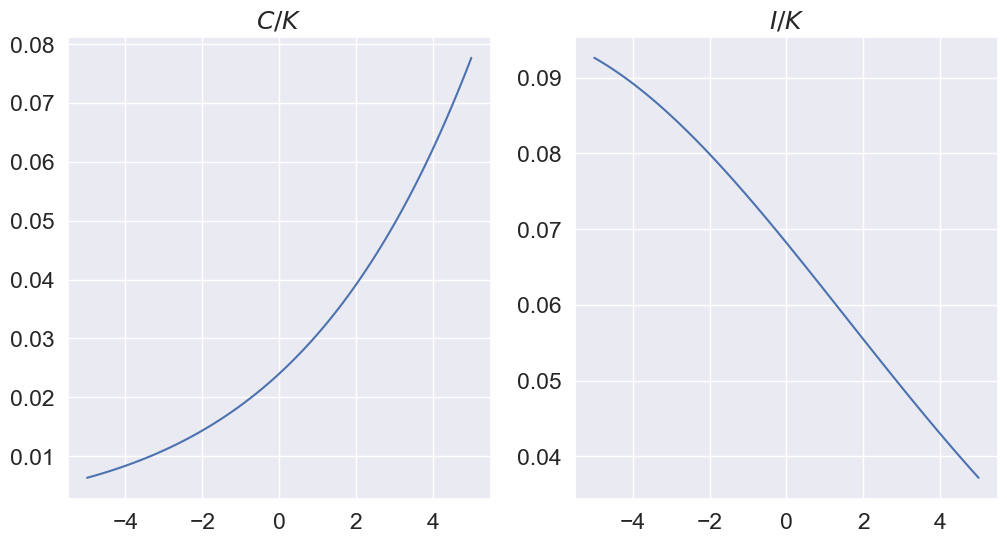

In [107]:
n_X = 3
n_W = 3
w = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 1).T
gkmean = ModelSol['ss'][3]
ymean = ModelSol['ss'][5]
# ymean = 2.0
ymean = 1e-5
gkmean = 0

def evaluate_z1(z1):
    # gkmean = ε * (ϕ_1 * anp.log(1.+ ϕ_2 * anp.exp(imk)) - α_k - 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*anp.exp(ymean))
    x1 = np.array([gkmean,z1,ymean]).reshape((n_X,1))
    x2 = np.array([gkmean,z1,ymean]).reshape((n_X,1))

    return ModelSol['JX_tp1'](*(x1,x2,w))

z1_grid = np.linspace(-5,5,100)
variables_z1 = np.array([evaluate_z1(z1) for z1 in z1_grid])

fig, axes = plt.subplots(1,2,figsize = (12,6))
axes[0].plot(z1_grid,np.exp(variables_z1[:,0,0]))
axes[0].set_title('$C/K$')
axes[1].plot(z1_grid,np.exp(variables_z1[:,1,0]))
axes[1].set_title('$I/K$')

In [97]:
z2_grid

array([-14.50865774, -14.47139633, -14.43413492, -14.39687351, -14.3596121 , -14.3223507 , -14.28508929, -14.24782788, -14.21056647, -14.17330506, -14.13604365, -14.09878224, -14.06152083,
       -14.02425943, -13.98699802, -13.94973661, -13.9124752 , -13.87521379, -13.83795238, -13.80069097, -13.76342957, -13.72616816, -13.68890675, -13.65164534, -13.61438393, -13.57712252,
       -13.53986111, -13.50259971, -13.4653383 , -13.42807689, -13.39081548, -13.35355407, -13.31629266, -13.27903125, -13.24176985, -13.20450844, -13.16724703, -13.12998562, -13.09272421,
       -13.0554628 , -13.01820139, -12.98093998, -12.94367858, -12.90641717, -12.86915576, -12.83189435, -12.79463294, -12.75737153, -12.72011012, -12.68284872, -12.64558731, -12.6083259 ,
       -12.57106449, -12.53380308, -12.49654167, -12.45928026, -12.42201886, -12.38475745, -12.34749604, -12.31023463, -12.27297322, -12.23571181, -12.1984504 , -12.16118899, -12.12392759,
       -12.08666618, -12.04940477, -12.01214336, -11.97

Text(0.5, 1.0, '$I/K$')

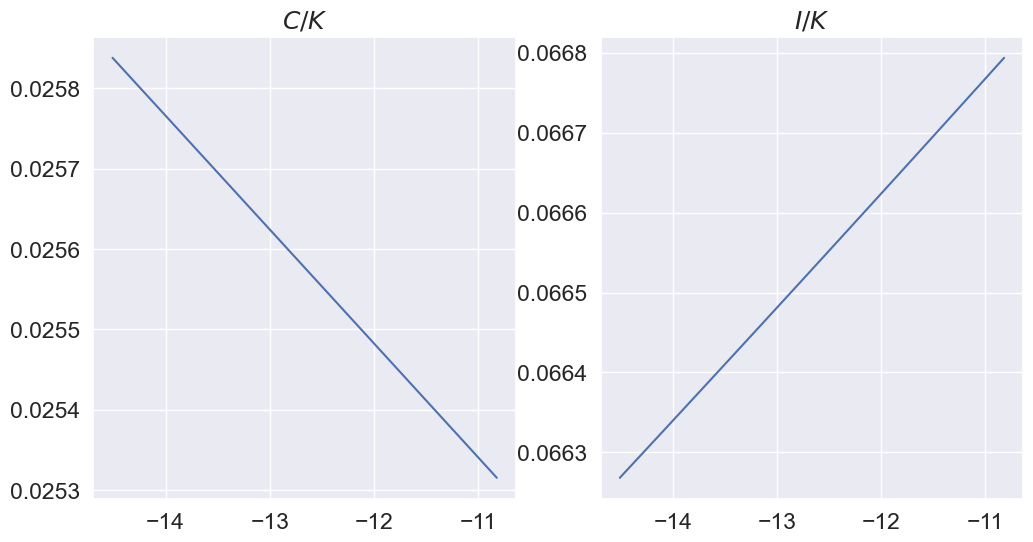

In [101]:
n_X = 3
n_W = 3
w = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 1).T
gkmean = ModelSol['ss'][3]

def evaluate_z2(z2):
    # gkmean = ε * (ϕ_1 * anp.log(1.+ ϕ_2 * anp.exp(imk)) - α_k - 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*anp.exp(ymean))
    x1 = np.array([gkmean,0,z2]).reshape((n_X,1))
    x2 = np.array([gkmean,0,z2]).reshape((n_X,1))

    return ModelSol['JX_tp1'](*(x1,x2,w))

z2_grid = np.linspace(np.log(0.0000005),np.log(0.00002),100)
variables_z2 = np.array([evaluate_z2(z2) for z2 in z2_grid])

fig, axes = plt.subplots(1,2,figsize = (12,6))
axes[0].plot(z2_grid,np.exp(variables_z2[:,0,0]))
axes[0].set_title('$C/K$')
axes[1].plot(z2_grid,np.exp(variables_z2[:,1,0]))
axes[1].set_title('$I/K$')

In [122]:
res_main = np.load("/Users/chh/BFI Dropbox/Chun Hei Hung/MFR_RP/QuantMFR/theory/RiskUncertaintyValue/data/res_continuous.npz")
dent = res_main['g']
Z, Y = res_main['zz'], res_main['yy']
d = res_main['d']
cons = res_main['cons']
phi = res_main['phi']
beta = res_main['beta']
eta = res_main['eta']
sigma_k = res_main['sigma_k']

def cdf(dent, statespace, statename):

    inverseCDFs = {}
    
    nRange   = list(range(len(statespace)))
    for i, state in enumerate(statespace):
        axes     = list(filter(lambda x: x != i,nRange))
        condDent = dent.sum(axis = tuple(axes))
        # cumden   = np.cumsum(condDent.copy())
        # cdf      = interpolate.interp1d(cumden, state, fill_value= (state.min(), state.max()), bounds_error = True)
        inverseCDFs[statename[i]] = condDent
        
    return inverseCDFs

marginal_quantile = cdf(dent, [np.unique(Z), np.unique(Y)], ['Z','Y'])

In [135]:
Ws = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 10000)
JX_sim = ModelSol.simulate(Ws)

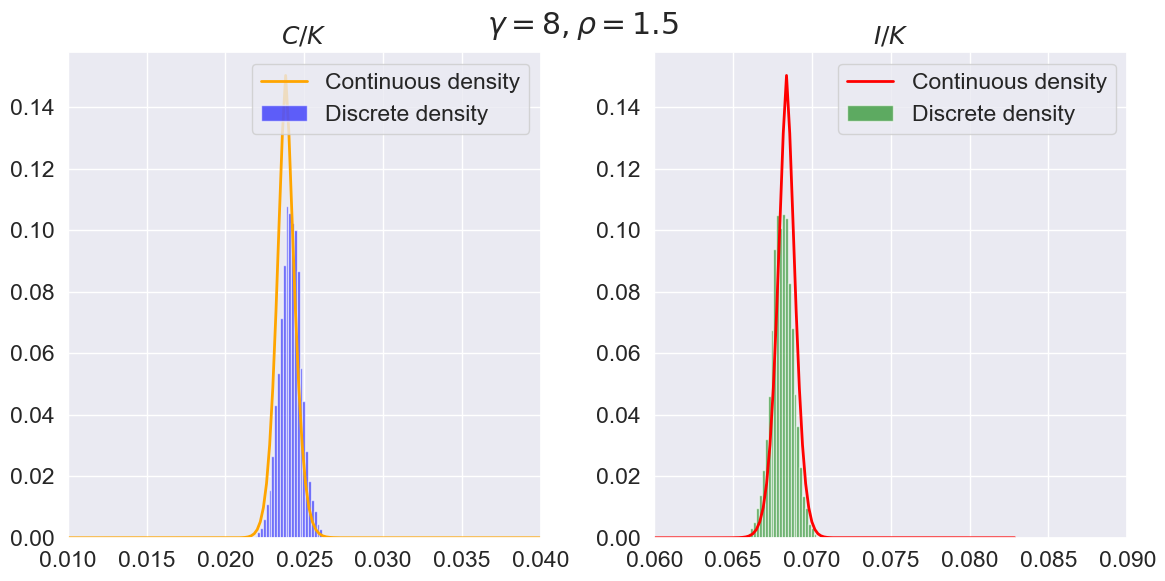

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First subplot - $C/K$
counts, bins, _ = ax[0].hist(np.exp(JX_sim[1000:, 0]), bins=30, density=False, color='blue', alpha=0.6)  # Histogram with probability
probabilities = counts / counts.sum()  # Normalize counts to get probabilities
ax[0].clear()  # Clear the old plot

# Plot probabilities
ax[0].bar(bins[:-1], probabilities, width=np.diff(bins), align='edge', color='blue', alpha=0.6, label="Discrete density")
ax[0].set_xlim(0.01, 0.04)
ax[0].set_title('$C/K$')

# Plot continuous density on the same axes (in different color)
ax[0].plot(cons[:, 50], dent[:, 50] / dent[:, 50].sum(), label='Continuous density', color='orange', linewidth=2)
ax[0].legend()

# Second subplot - $I/K$
counts, bins, _ = ax[1].hist(np.exp(JX_sim[1000:, 1]), bins=30, density=False, color='green', alpha=0.6)  # Histogram with probability
probabilities = counts / counts.sum()  # Normalize counts to get probabilities
ax[1].clear()  # Clear the old plot

# Plot probabilities
ax[1].bar(bins[:-1], probabilities, width=np.diff(bins), align='edge', color='green', alpha=0.6, label="Discrete density")
ax[1].set_xlim(0.06, 0.09)
ax[1].set_title('$I/K$')

# Plot continuous density on the same axes (in different color)
ax[1].plot(d[:, 50], dent[:, 50] / dent[:, 50].sum(), label='Continuous density', color='red', linewidth=2)
ax[1].legend()

plt.tight_layout()
plt.suptitle(rf"$\gamma=8,\rho=1.5$")
plt.savefig("plots/density_comparison_gamma8_rho15.png")

plt.show()

In [264]:
def log_SDF_ex(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N and Q.

    # Parameters for the model 
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_k3, sigma_z1, sigma_z2, sigma_z3, sigma_y1, sigma_y2, sigma_y3, beta_2, mu_2, ε = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    cmk_t, imk_t, mk_t, gk_t, Z_t, Y_t = Var_t.ravel()
    cmk_tp1, imk_tp1, mk_tp1, gk_tp1, Z_tp1, Y_tp1 = Var_tp1.ravel()

    sdf_ex = anp.log(β) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    
    return sdf_ex

expo_elas, price_elas = ModelSol.elasticities(log_SDF_ex, T=40, shock=1)
states, controls = ModelSol.IRF(T = 40, shock = 1) 

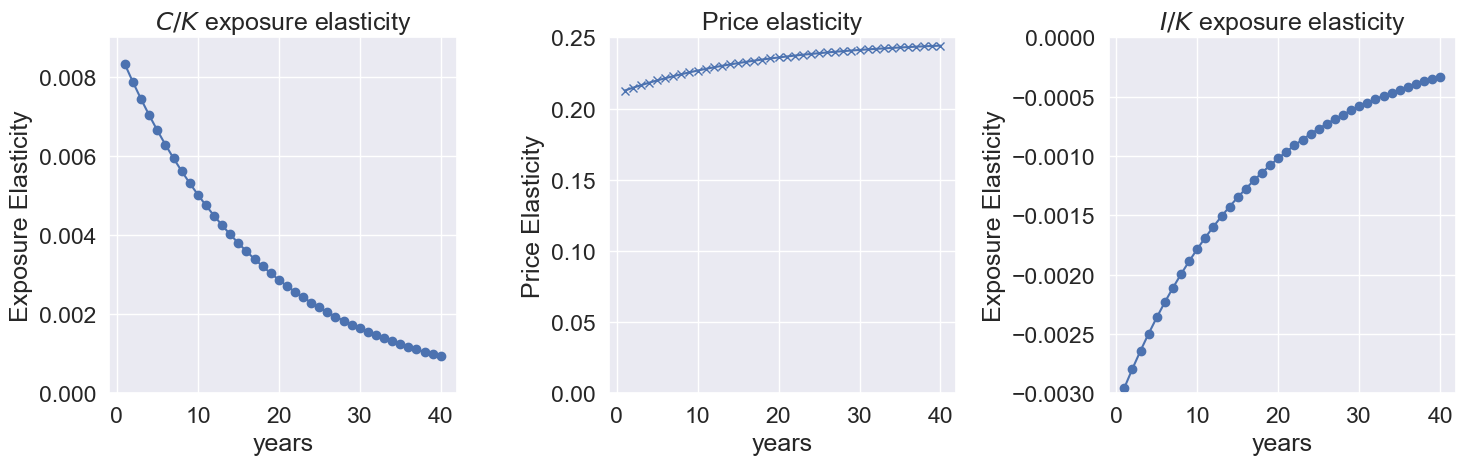

In [266]:
# import matplotlib.pyplot as plt

time_periods = list(range(1, 41))  # 40 time periods starting from 1

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Plotting Exposure Elasticity in the first subfigure
axs[2].plot(time_periods, expo_elas[:, 1], label='Exposure Elasticity', marker='o')
axs[2].set_xlabel('years')
axs[2].set_ylabel('Exposure Elasticity')
axs[2].set_title(r"$I/K$ exposure elasticity")
axs[2].grid(True)

# Plotting Exposure Elasticity in the first subfigure
axs[0].plot(time_periods, expo_elas[:, 0], label='Exposure Elasticity', marker='o')
axs[0].set_xlabel('years')
axs[0].set_ylabel('Exposure Elasticity')
axs[0].set_title(r"$C/K$ exposure elasticity")
axs[0].grid(True)

# Plotting Price Elasticity in the second subfigure
axs[1].plot(time_periods, price_elas[:, 1], label='Price Elasticity', marker='x')
axs[1].set_xlabel('years')
axs[1].set_ylabel('Price Elasticity')
axs[1].set_title(r"Price elasticity")
axs[1].grid(True)

# # Plotting IRF in the third subfigure
# axs[2].plot(time_periods, controls[:, 0], label='IRF', marker='^')
# axs[2].set_xlabel('Time Period')
# axs[2].set_ylabel('Impulse Response')
# axs[2].set_title('IRF Over Time')
# axs[2].grid(True)
# axs[0].set_ylim(0,0.008)
axs[2].set_ylim(-0.003,0)
axs[1].set_ylim(0,0.25)
axs[0].set_ylim(0,0.009)

plt.tight_layout()
plt.show()

array([ -3.6609563 ,  -2.71067238,   1.55764458,   0.01328413,   0.        , -12.13375198])

<br>
<br>
<br>

# 3 Outputs

## 3.1 List of Outputs <a class="anchor" id="s3-1"></a>

We now examine the contents of `ModelSol`, which contains the attributes listed below. Each approximation is stored in a class `LinQuadVar`, which contains the coefficients for $X_{1,t}, X_{2,t}, X_{1,t}'X_{1,t}, W_{t+\epsilon}, W_{t+\epsilon}'W_{t+\epsilon}, X_{1,t}'W_{t+\epsilon}$ and the constant.


```{list-table}
:header-rows: 1

* - Input
  - Type
  - Description
* - `JXn_t`
  - *LinQuadVar*
  - Approximation of jump and state variables at time $t$. Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. The variables are indexed in the order specified in Section 2. 
* - `Jn_t`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to jump variables.
* - `Xn_tp1`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to state variables.
* - `JXn_t_tilde`
  - *LinQuadVar*
  - Same as `JXn_t` but using distorted measure. This variation is also available for `Jn_t` and `Xn_tp1`.
* - `util_sol`
  - *dict*
  - Dictionary containing solutions of the continuation values, including $\mu^0, \Upsilon_0^2, \Upsilon_1^2,$ and $\Upsilon_2^2$ etc.
* - `vmrn_tp1`
  - *LinQuadVar*
  - Approximation of continuation values $\widehat{V}^1_{t+\epsilon}-\widehat{R}^1_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `gcn_tp1`
  - *LinQuadVar*
  - Approximation of consumption growth $\widehat{C}_{t+\epsilon}-\widehat{C}_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `ss`
  - *dict*
  - Steady states for state and jump variables
* - `log_N_tilde`
  - *LinQuadVar*
  - Approximation for the log change of measure
```

For example, we can obtain the coefficients for the first-order contribution of $\log{C_t/K_t}$ in the following way, noting that `cmk_t` was listed as the first jump variable when we specified the equilibrum conditions.


In [9]:
## Log consumption over capital approximation results, shown in the LinQuadVar coefficients form
ModelSol['JX1_t'][0].coeffs

{'x': array([[ 0.04344641, -0.        ]]), 'c': array([[-0.02117949]])}

We can also display the full second-order approximation of $\log{C_t/K_t}$ using the `disp` function, which renders a `LinQuadVar` object in LATEX form.

In [10]:
## Log consumption over capital approximation results, shown in the Latex analytical form
disp(ModelSol['JX_t'][0],'\\log\\frac{C_t}{K_t}') 

<IPython.core.display.Math object>

Another example:

In [11]:
## Log capital growth process second order approximation results
disp(ModelSol['X2_tp1'][0],'\\log\\frac{K_{t+\epsilon}^2}{K_t^2}') 

<IPython.core.display.Math object>


## 3.2 Approximate Related Variables <a class="anchor" id="s3-2"></a>

We can use the method `ModelSol.approximate` to approximate variables which can be expressed as functions of the state and jump variables. For example, suppose we want to approximate log investment growth $\log{I_{t+\epsilon}/I_t}$. We can express this as:

$$
\log{I_{t+\epsilon}/I_t} = \log{I_{t+\epsilon}/K_{t+\epsilon}} + \log{K_{t+\epsilon}/K_t} - \log{I_t/K_t}
$$

We use this expression to write the function `gi_tp1_approx`, which is used as an input in `ModelSol.approximate` below.

In [12]:
def gi_tp1_approx(Var_t, Var_tp1, W_tp1, q, *args):

    # Parameters for the model
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z1, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`)
    cmk_t, imk_t, mkmc_t, Z_t, gk_t = Var_t.ravel()
    cmk_tp1, imk_tp1, mkmc_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()
    
    gi_tp1 = imk_tp1 + gk_tp1 -imk_t
    
    return gi_tp1

n_J, n_X, n_W = var_shape
gi_tp1_list = ModelSol.approximate(gi_tp1_approx, args)
gi_tp1 = {'gi_tp1':gi_tp1_list[0],\
        'gi0_tp1':gi_tp1_list[1],\
        'gi1_tp1':gi_tp1_list[2],\
        'gi2_tp1':gi_tp1_list[3]}
gi_tp1['gi1_tp1'].coeffs

{'x': array([[ 0.01018563, -0.        ]]),
 'c': array([[0.00035532]]),
 'w': array([[ 0.00917057, -0.00083961]])}

<br>

## 3.3 Simulate Variables <a class="anchor" id="s3-3"></a>
Given a series of shock processes, we can simulate the path of our state and jump variables using the `ModelSolution.simulate` method. Here, we simulate 400 periods of i.i.d standard multivariate normal shocks.

In [13]:
Ws = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 400)
JX_sim = ModelSol.simulate(Ws)

<br>

## 3.4 Shock Elasticities and IRF <a class="anchor" id="s3-4"></a>

`ModelSolution` contains a method `elasticities` used to compute the shock elasticities of jump and state variables. We do this by defining a `log_SDF_ex` function, which expresses the log stochastic discount factor exclusive of the change of measure ${N}^*_{t+\epsilon}$ and variable $Q_{t+\epsilon}^*$. Shock elasticities are great tools for nonlinear impulsive response analyses, and in linear models, the shock elasticities correspond to the traditional impulse response function (IRF). 

`ModelSolution` also has a method `IRF` to compute the traditional IRF of all jump and state variables. Below we calculate the IRF of all variables with respect to the first shock for 400 periods.

The figure plots elasticities and IRF of investment rate with regard to shock 1. 

In [14]:
def log_SDF_ex(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N and Q.

    # Parameters for the model 
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_z = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    cmk_t, imk_t, mk_t, Z_t, gk_t = Var_t.ravel()
    cmk_tp1, imk_tp1, mk_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()

    sdf_ex = anp.log(β) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    
    return sdf_ex

expo_elas, price_elas = ModelSol.elasticities(log_SDF_ex, T=40, shock=0)
states, controls = ModelSol.IRF(T = 40, shock = 0) 

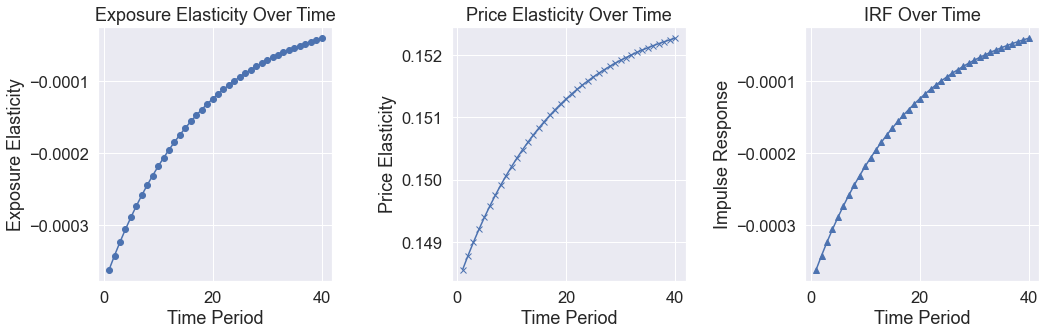

In [15]:
import matplotlib.pyplot as plt

time_periods = list(range(1, 41))  # 40 time periods starting from 1

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Plotting Exposure Elasticity in the first subfigure
axs[0].plot(time_periods, expo_elas[:, 1], label='Exposure Elasticity', marker='o')
axs[0].set_xlabel('Time Period')
axs[0].set_ylabel('Exposure Elasticity')
axs[0].set_title('Exposure Elasticity Over Time')
axs[0].grid(True)

# Plotting Price Elasticity in the second subfigure
axs[1].plot(time_periods, price_elas[:, 1], label='Price Elasticity', marker='x')
axs[1].set_xlabel('Time Period')
axs[1].set_ylabel('Price Elasticity')
axs[1].set_title('Price Elasticity Over Time')
axs[1].grid(True)

# Plotting IRF in the third subfigure
axs[2].plot(time_periods, controls[:, 1], label='IRF', marker='^')
axs[2].set_xlabel('Time Period')
axs[2].set_ylabel('Impulse Response')
axs[2].set_title('IRF Over Time')
axs[2].grid(True)

plt.tight_layout()
plt.show()



<br>
<br>

# 4 Using `LinQuadVar` in Computation <a class="anchor" id="s2"></a>

In the previous section, we saw how to use `uncertain_expansion` to approximate variables and store their coefficients as `LinQuadVar` objects. In this section, we explore how to manipulate `LinQuadVar` objects for different uses.

To aid our examples, we first extract the steady states for the state evolution processes from the previous model solution:

See [src/lin_quad.py](https://github.com/lphansen/RiskUncertaintyValue/blob/main/src/lin_quad.py) for source code of `LinQuadVar` definition.

In [43]:
n_J, n_X, n_W = ModelSol['var_shape']
X0_tp1 = LinQuadVar({'c':np.array([[ModelSol['ss'][1]],[ModelSol['ss'][2]]])}, shape = (2, n_X, n_W))
X0_tp1.coeffs

{'c': array([[-2.71057934],
        [ 1.5576879 ]])}

## 4.1 `LinQuadVar` Operations <a class="anchor" id="s4-1"></a>
We can sum multiple LinQuads together in two different ways. Here we demonstrate this with an example by summing the zeroth, first and second order contributions of our approximation for capital growth. 

In [44]:
gk_tp1 = X0_tp1[0] + ModelSol['X1_tp1'][0]  + 0.5 * ModelSol['X2_tp1'][0] 
disp(gk_tp1,'\\log\\frac{K_{t+\epsilon}}{K_t}') 

<IPython.core.display.Math object>

In the next example, we sum together the contributions for both capital growth and technology:

In [45]:
lq_sum([X0_tp1, ModelSol['X1_tp1'], 0.5 * ModelSol['X2_tp1']]).coeffs

{'c': array([[-2.71057934],
        [ 1.55804585]]),
 'w': array([[0.022  , 0.05   ],
        [0.00954, 0.     ]]),
 'x2': array([[0.47276957, 0.        ],
        [0.00463556, 0.        ]]),
 'xx': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001424, -0.        ,  0.        ,  0.        ]]),
 'x': array([[0.94553914, 0.        ],
        [0.00928281, 0.        ]])}

## 4.2 `LinQuadVar` Split and Concat <a class="anchor" id="s4-2"></a>
`split` breaks multiple dimensional LinQuad into one-dimensional LinQuads, while `concat` does the inverse.

In [46]:
gk_tp1, Z_tp1 = ModelSol['X1_tp1'].split()
concat([gk_tp1, Z_tp1])

## 4.3 Evaluate a `LinQuadVar` <a class="anchor" id="s4-3"></a>
We can evaluate a LinQuad at specific state $(X_{t},W_{t+\epsilon})$ in time. As an example, we evaluate all 5 variables under steady state with a multivariate random normal shock.

In [47]:
x1 = np.zeros([n_X ,1])
x2 = np.zeros([n_X ,1])
w = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 1).T
ModelSol['JX_tp1'](*(x1,x2,w))

array([[-3.68228516],
       [-2.70254332],
       [ 1.56144343],
       [ 0.01147443],
       [ 0.02648373]])

## 4.4 Next period expression for `LinQuadVar` <a class="anchor" id="s4-4"></a>
`ModelSol` allows us to express a jump variable $J_t$ as a function of $t$ state and shock variables. Suppose we would like to compute its next period expression $J_{t+\epsilon}$ with shocks. The function `next_period` expresses $J_{t+\epsilon}$ in terms of $t$ state variables and $t+\epsilon$ shock variables. For example, we can express the $t+\epsilon$ expression for the first-order contribution to consumption over capital as:

In [48]:
cmk1_tp1 = next_period(ModelSol['J1_t'][0], ModelSol['X1_tp1'])
disp(cmk1_tp1, '\\log\\frac{C_{t+\epsilon}^1}{K_{t+\epsilon}^1}') 

<IPython.core.display.Math object>

In [49]:
cmk2_tp1 = next_period(ModelSol['J2_t'][0], ModelSol['X1_tp1'], ModelSol['X2_tp1'])
disp(cmk2_tp1, '\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}') 

<IPython.core.display.Math object>

## 4.6 Compute the Expectation of time $t+\epsilon$ `LinQuadVar` <a class="anchor" id="s4-6"></a>

Suppose the distribution of shocks has a constant mean and variance (not state dependent). Then, we can use the `E` function to compute the expectation of a time $t+\epsilon$ `LinQuadVar` as follows:


In [50]:
E_w = ModelSol['util_sol']['μ_0']
cov_w = np.eye(n_W)
E_ww = cal_E_ww(E_w, cov_w)
E_cmk2_tp1 = E(cmk2_tp1, E_w, E_ww)
disp(E_cmk2_tp1, '\mathbb{E}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>

Suppose the distribution of shock has a state-dependent mean and variance (implied by $\tilde{N}_{t+\epsilon}$ shown in the notes), we can use `E_N_tp1` and `N_tilde_measure` to compute the expectation of time $t+\epsilon$ `LinQuadVar`.

In [51]:
N_cm = N_tilde_measure(ModelSol['util_sol']['log_N_tilde'],(1,n_X,n_W))
E_cmk2_tp1_tilde = E_N_tp1(cmk2_tp1, N_cm)
disp(E_cmk2_tp1_tilde, '\mathbb{\\tilde{E}}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>